# Brain Tumor Detection in MRI Images Using Deep Learning
## YOLOv8-Based Localisation and ResNet Classification Pipeline

**Group Members:** Sammi, Dhirana, Sakthi, Sokheng, Mitch  

##  **1. Introduction**

Brain tumours are among the most critical abnormalities that can appear in the human brain.
Magnetic Resonance Imaging (MRI) is the standard non-invasive imaging modality for detecting such tumours.
However, manual interpretation of MRI scans is time-consuming, requires specialised expertise, and can be prone to human error.

In this project, we aim to build an **automated pipeline** to:

1. **Classify** each MRI slice as either **Healthy** or **Tumour**.
2. **Pre-process and clean** the raw MRI images so that they are consistent and model-ready.
3. Train a **YOLOv8-based classification model** on the cleaned dataset and evaluate it using metrics such as **accuracy**, **F1-score**, and **ROC-AUC**.
4. Train a **(ResNet-18 & EfficientNet-B0)** binary classification model on the cleaned MRI images and evaluate its performance using accuracy, F1-score, and ROC-AUC.

Our high-level workflow is:

1. **Exploratory Data Analysis (EDA) & Preprocessing Design** – inspect the dataset structure, verify image integrity, understand class distribution, and identify issues such as inconsistent image sizes, noise, or blank borders. Based on these findings, we define a preprocessing strategy (cropping to remove black borders, standardizing image size, normalizing pixel values, and optional contrast enhancement).
2. **MRI Cleaning Pipeline** – implement the preprocessing steps consistently across all images.
3. **Model Training (ResNet-18 & EfficientNet-B0)** – train and evaluate the classifier on the annotated dataset.
4. **Model Training (YOLOv8)** – train and evaluate the classifier on the cleaned dataset.

The rest of this notebook follows this structure.


##  **2. Problem  Statment**

### **2.1 Task Definition**

The goal of this project is to develop an **automated deep learning pipeline** that can analyse brain MRI images and determine whether a scan belongs to a **Healthy** brain or a **Tumour** brain.

Formally, the task is to perform **supervised binary classification** on MRI images, where the model predicts whether an input image belongs to Class 0 (Healthy) or Class 1 (Tumour).

To support this pipeline, we incorporate two complementary components:

- **YOLOv8** – used for **localising potential tumour regions** through bounding box detection  
- **ResNet & EfficientNet classifier** – used for **final binary classification** on the cleaned and standardised MRI images  

This two-stage approach enables the system to both identify **where** abnormalities may appear and determine **whether** the MRI should be flagged for tumour presence.


### **2.2 Motivation**

Detecting brain tumours from MRI scans is a critical clinical task. Radiologists must review many images, and this process can be slow and sometimes inconsistent, especially when tumours are small or low-contrast.

Early and accurate tumour identification is essential because treatment planning and patient outcomes rely heavily on timely detection. Automated tools can help by quickly highlighting scans that may require closer examination.

Our aim is not to replace radiologists, but to provide a reliable first-pass screening step that improves workflow efficiency, supports triaging, and reduces the chance of missing potential abnormalities.



### **2.3 Performance Metrics Selection**

**ResNet & EfficientNet**

ResNet-18 and EfficientNet-B0 perform the Healthy vs Tumour classification task. To measure classifier performance, we use:

Accuracy: Overall proportion of correct predictions.

Precision: How many predicted tumours were true tumours.


F1-score: Harmonic mean of precision and recall; robust for imbalanced datasets.

ROC-AUC: Measures how well the model separates the two classes across decision thresholds.

**YoloV8 Model 1 & Model 2**

Model 1: Learn to detect tumor regions and being gauged on its performance before  it's used for pseudo-labeling the rest of the dataset.

Percision: Predicts tumor bouding boxes actually corresponded to real tumors.

mAP: Assessment of the model's ability to precisely localize objects.

Model 2: Primary tumor localization component of the overall brain tumor dection pipline.

Confusion Matrix: A summarized table of classification model. Directly shows the types of errors a model makes.

F1-Score: A high F1-score indicates a good balance between identifying positive cases and not incorrectly classifying negative cases.

ROC-AUC: Measures the model's ability to distinguish between classes across all possible classification thresholds.




## **3. Dataset Understanding**


This section provides a high-level overview of the MRI brain tumour dataset and verifies that the metadata and image files are correctly aligned before any exploratory analysis or preprocessing is performed.


### **3.1 Metadata Loading**
In this step, we:

1. Import Libraries  
2. Mount Google Drive
2. Define the dataset directory  
3. Load `metadata.csv` into a dataframe  
4. Inspect the structure of the dataframe using `.shape`, `.head()`, and `.info()`  

This confirms that the metadata has been loaded correctly and that key fields (`image`, `class`) are present.


In [ ]:
pip install opencv-python-headless numpy tqdm pillow imagehash scikit-learn torch torchvision


In [ ]:
# 3.1.1 Metadata Loading

import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import imagehash
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import random
from concurrent.futures import ThreadPoolExecutor
from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances

import torch
import torch.nn as nn
from torchvision import models, transforms
from torchvision.models import EfficientNet_B0_Weights, ResNet18_Weights
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Mount Google Drive and set base path to dataset
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/dsaDataset"

# Load metadata CSV
df = pd.read_csv(base_path + "/metadata.csv")
print("Shape of metadata:", df.shape)

# Quick preview of metadata
display(df.head())
print("\nDataFrame info:")
print(df.info())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape of metadata: (4600, 6)


,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4600 non-null   int64 
 1   image       4600 non-null   object
 2   class       4600 non-null   object
 3   format      4600 non-null   object
 4   mode        4600 non-null   object
 5   shape       4600 non-null   object
dtypes: int64(1), object(5)
memory usage: 215.8+ KB
None


### **3.2 Metadata Integrity Checks**

Before diving into exploratory analysis, we perform basic validation of the metadata.

We check for:

- **Missing values** in each column  
- **Duplicate rows** in the CSV  
- Whether each row in the CSV actually maps to an existing image file on disk  


In [ ]:
# 3.2.1 Missing values & duplicate rows

print("Missing values per column:")
display(df.isna().sum())

num_duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    print("\nDuplicate rows:")
    display(df[df.duplicated(keep=False)])


Missing values per column:


,0
Unnamed: 0,0
image,0
class,0
format,0
mode,0
shape,0



Number of duplicate rows: 0


In [ ]:
# 3.2.2 Mapping metadata rows to image paths and checking existence

def row_to_path(row):
    """
    Map a metadata row to its corresponding image file path.
    Assumes 'class' is either 'tumor' or 'normal' (healthy).
    """
    folder = "Brain Tumor" if row["class"] == "tumor" else "Healthy"
    return base_path + "/" + folder + "/" + row["image"]

# Check if all image paths exist
missing_files = [
    row_to_path(r)
    for _, r in df.iterrows()
    if not os.path.exists(row_to_path(r))
]

print("Number of missing image files:", len(missing_files))

if len(missing_files) > 0:
    print("Example missing file path:", missing_files[0])


Number of missing image files: 0


### **3.4 Dataset Volume Summary**

In [ ]:
# 3.4.1 Dataset Volume Summary

healthy_path = base_path + "/Healthy"
tumor_path   = base_path + "/Brain Tumor"

healthy_images = [f for f in os.listdir(healthy_path) if not f.startswith('.')]
tumor_images   = [f for f in os.listdir(tumor_path)   if not f.startswith('.')]

print("Number of healthy images (folder):", len(healthy_images))
print("Number of tumor images (folder):  ", len(tumor_images))
print("Number of rows in metadata CSV:   ", len(df))

# Quick cross-check of class counts from metadata
print("\nClass counts from metadata:")
print(df["class"].value_counts())


Number of healthy images (folder): 2087
Number of tumor images (folder):   2513
Number of rows in metadata CSV:    4600

Class counts from metadata:
class
tumor     2513
normal    2087
Name: count, dtype: int64


##  **4. Exploratory Data Analysis (EDA)**

In this section, we explore the visual and statistical characteristics of the MRI dataset.
The goal of EDA is to:

- Build intuition about how tumour vs healthy MRI slices differ visually  
- Examine class balance  
- Verify that image properties (resolution, mode, format) behave consistently  
- Identify potential issues that will influence preprocessing decisions  

All insights from this section will directly guide the design of our **MRI Cleaning Pipeline**.


### **4.1 Visual Inspection of Random Healthy and Tumour Images**
We begin by randomly displaying MRI images from each class.

This helps us understand:

- Variability in contrast and brightness  
- Typical appearance of tumour regions  
- Possible noise or artefacts  
- Whether images differ significantly in orientation or cropping  

These visual cues strongly influence how we design the cleaning and augmentation pipeline.



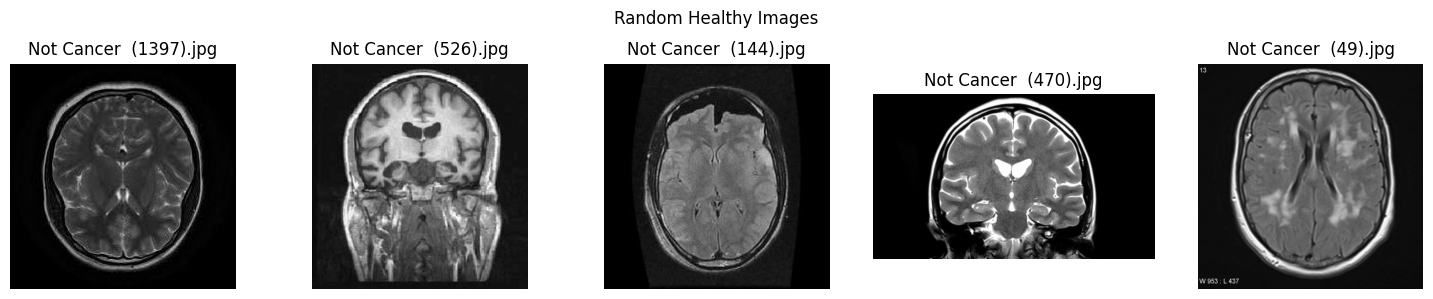

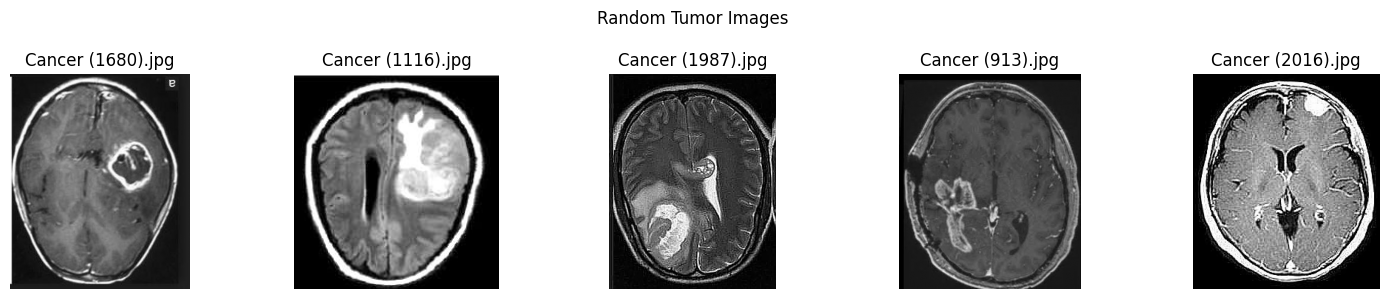

In [ ]:
# 4.1.1 Sample Images
def show_random_images(df_class, n=5, title="Samples"):
    """
    Display n random images from a filtered dataframe (df[df['class']=='healthy'] or 'tumor']).
    Uses row_to_path().
    """
    if df_class.empty:
        print(f"No images found for {title}")
        return

    # Sample N rows
    subset = df_class.sample(n=min(n, len(df_class)), random_state=None)

    # Begin plotting
    plt.figure(figsize=(3 * len(subset), 3))

    for i, (_, row) in enumerate(subset.iterrows(), start=1):
        img_path = row_to_path(row)

        try:
            img = Image.open(img_path).convert("L")
        except Exception as e:
            print(f"Error reading image at {img_path}: {e}")
            continue

        plt.subplot(1, len(subset), i)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(os.path.basename(img_path))

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# Run for each class
show_random_images(df[df["class"] == "normal"], n=5, title="Random Healthy Images")
show_random_images(df[df["class"] == "tumor"],   n=5, title="Random Tumor Images")


### **4.2 Class Distribution**

From this plot, we can see:

- How many images are labelled **tumour** vs **normal/healthy**.
- Whether the classes are reasonably balanced or if there is class imbalance.

This information will influence:

- Whether we need **class weighting** or **data augmentation** for the minority class during model training.
- How we interpret evaluation metrics later on.

Healthy images: 2087
Tumor images: 2513


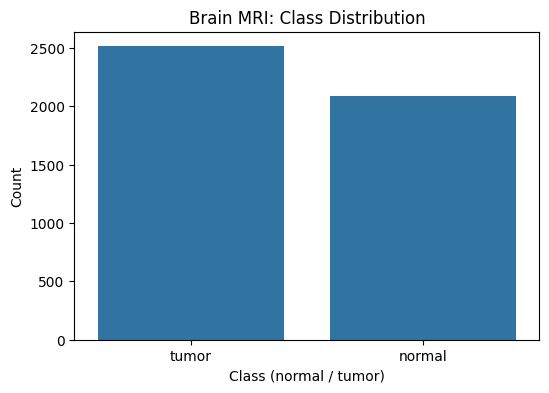

In [ ]:
# 4.2.1 Class distribution visualization

healthy_path = base_path + "/Healthy"
tumor_path   = base_path + "/Brain Tumor"

healthy_images = [f for f in os.listdir(healthy_path)]
tumor_images = [f for f in os.listdir(tumor_path)]

print("Healthy images:", len(healthy_images))
print("Tumor images:", len(tumor_images))

plt.figure(figsize=(6,4))
sns.countplot(x='class', data=df)
plt.title("Brain MRI: Class Distribution")
plt.xlabel("Class (normal / tumor)")
plt.ylabel("Count")
plt.show()

### 4.3 **Mode Distribution**

We visualise the distribution of these modes to understand how consistent the raw data is.

Key questions we answer here:
- Are most images RGB, or are many grayscale?
- Do we need to **standardise** the colour mode before feeding images to the model?


**Connection to MRI Cleaning Pipeline:**  

MRIs are intensity-based, so RGB channels add no meaningful information.  
If most images are RGB, we will **convert all images to grayscale** so our models receive a consistent single-channel input.


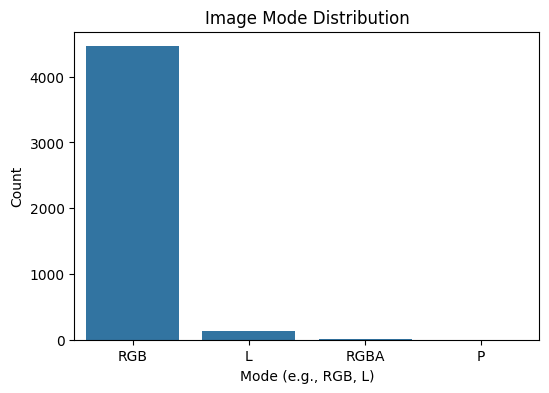

In [ ]:
# 4.3.1 Mode distribution visualization
plt.figure(figsize=(6,4))
sns.countplot(x='mode', data=df)
plt.title("Image Mode Distribution")
plt.xlabel("Mode (e.g., RGB, L)")
plt.ylabel("Count")
plt.show()

### 4.4 **Distribution of Image Dimensions(Scatter Plot)**

MRI images in the dataset come in multiple shapes (e.g., 256×256, 512×512).  

We visualise the spread of image dimensions to understand this variability.

**Connection to MRI Cleaning Pipeline:**  

Because raw images do not share a fixed size, we will **resize all images to a uniform resolution (e.g., 224×224)** so our models receive standardised inputs during training.


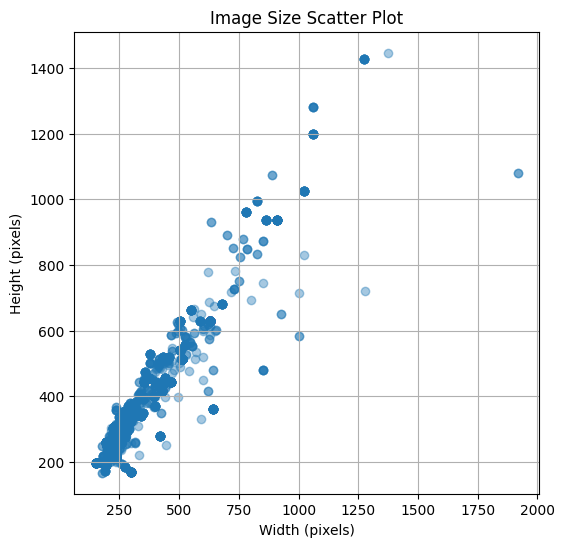

In [ ]:
# 4.3.1 Scatter Plot of Image Dimensions
def get_size(path):
    with Image.open(path) as img:
        return img.width, img.height

paths = [row_to_path(row) for _, row in df.iterrows()]

widths = []
heights = []

with ThreadPoolExecutor(max_workers=16) as ex:
    for w, h in ex.map(get_size, paths):
        widths.append(w)
        heights.append(h)
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(widths, heights, alpha=0.4)
plt.title("Image Size Scatter Plot")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.grid(True)
plt.show()

### 4.5 **Pixel Intensity Distributions for Healthy vs Tumour**

Beyond shape and mode, we also want to understand how **pixel intensities** are distributed for each class.

We:

1. Sample a subset of **healthy** images and **tumour** images.
2. Convert them to grayscale.
3. Collect all pixel values and plot histograms.

This helps us see:

- Whether tumour images tend to have different overall brightness or contrast.
- Why it is important to apply **intensity normalisation** and **contrast enhancement (CLAHE)** in the MRI Cleaning Pipeline.

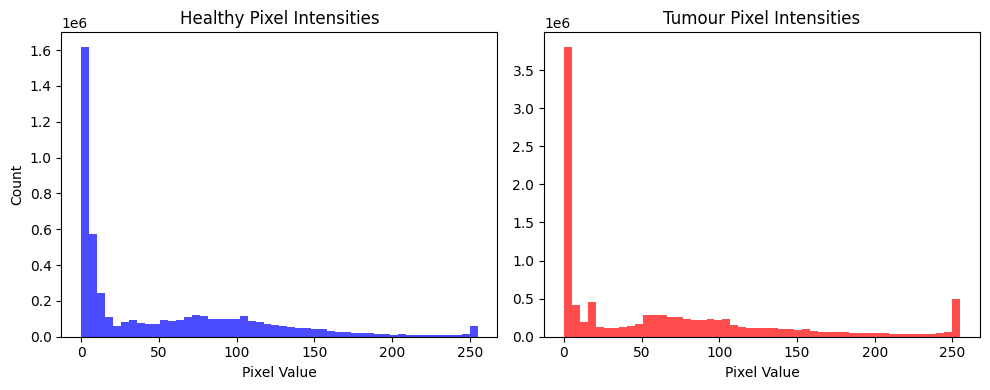

In [ ]:
def get_intensity_values(class_name, max_images=50):
    """Returns a 1D array of grayscale pixel values for a sampled set of images."""

    # sample metadata rows
    rows = df[df["class"] == class_name].sample(max_images, random_state=42)

    all_pixels = []

    for _, r in rows.iterrows():
        try:
            img = Image.open(row_to_path(r)).convert("L")
            img = np.array(img, dtype=np.float32)
            all_pixels.extend(img.flatten())
        except:
            continue

    return np.array(all_pixels)


healthy_pixels = get_intensity_values("normal", 50)
tumor_pixels   = get_intensity_values("tumor",  50)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(healthy_pixels, bins=50, color='blue', alpha=0.7)
plt.title("Healthy Pixel Intensities")
plt.xlabel("Pixel Value")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(tumor_pixels, bins=50, color='red', alpha=0.7)
plt.title("Tumour Pixel Intensities")
plt.xlabel("Pixel Value")

plt.tight_layout()
plt.show()


## **5. MRI Cleaning and Preprocessing Pipeline**

This section:
- Loads raw MRI images
- Performs cleaning fundamentals
- Removes black borders and crops brain region
- Normalizes intensities
- Enhances contrast using CLAHE
- Removes duplicates using perceptual hashing
- Detects outliers using ResNet embeddings
- Splits dataset into train/val/test
- Outputs cleaned dataset ready for CNN training

### Input:
`data_raw/`  
 ├── `healthy/`  
 └── `tumour/`

### Output:
`data_clean_complete/`  
 ├── `train/healthy`  
 ├── `train/tumour`  
 ├── `val/healthy`  
 ├── `val/tumour`  
 ├── `test/healthy`  
 └── `test/tumour`

---


### **5.1 Define paths and output directories**

In [ ]:
#RAW_DIR = Path("../data_raw")
RAW_DIR = Path(base_path)

OUT_DIR = Path("../data_clean_complete")

# clean previous outputs done prev trials? (optional safety)
if OUT_DIR.exists():
    shutil.rmtree(OUT_DIR)

# create folders
for split in ["train", "val", "test"]:
    for cls in ["healthy", "tumour"]:
        (OUT_DIR / split / cls).mkdir(parents=True, exist_ok=True)

# CLASS_MAP = {
#     "healthy": "healthy",
#     "tumour": "tumour"
# }

CLASS_MAP = {
    "Healthy": "healthy",
    "Brain Tumor": "tumour"
}


IMG_SIZE = 224

### **5.2 Basic utility Functions**

In [ ]:
def normalize_intensity(img):
    img = img.astype("float32")
    p1, p99 = np.percentile(img, (1, 99))
    img = np.clip(img, p1, p99)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return img




def get_brain_bbox(img, threshold=5):
    _, mask = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not cnts:
        return 0, 0, img.shape[1], img.shape[0]

    c = max(cnts, key=cv2.contourArea)
    return cv2.boundingRect(c)




clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def apply_clahe(img_float):
    img_uint8 = (img_float * 255).astype("uint8")
    enhanced = clahe.apply(img_uint8)
    return enhanced.astype("float32") / 255.0

### **5.3 Combined cleaning (crop->resize->normalise->CLAHE)**

In [ ]:
def clean_image(path, use_clahe=True):
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    # Crop brain region
    x, y, w, h = get_brain_bbox(img)
    img = img[y:y+h, x:x+w]

    # Resize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)

    # Intensity normalization
    img = normalize_intensity(img)

    # Contrast enhancement (optional)
    if use_clahe:
        img = apply_clahe(img)

    # Convert to uint8 for saving
    return (img * 255).astype("uint8")


### **5.4 Clean all raw images into a temporary folder**


In [ ]:
TEMP_DIR = Path("../data_temp_clean")
if TEMP_DIR.exists():
    shutil.rmtree(TEMP_DIR)

for cls_source in CLASS_MAP:
    (TEMP_DIR / CLASS_MAP[cls_source]).mkdir(parents=True, exist_ok=True)

# process all raw images
for cls_source, cls_target in CLASS_MAP.items():
    cls_dir = RAW_DIR / cls_source          # data_raw/healthy or data_raw/tumour
    for fname in tqdm(os.listdir(cls_dir), desc=f"Cleaning {cls_source}"):
        img = clean_image(cls_dir / fname)
        if img is not None:
            cv2.imwrite(str(TEMP_DIR / cls_target / fname), img)


Cleaning Brain Tumor: 100%|██████████| 2513/2513 [01:08<00:00, 36.60it/s]


### **5.5 Detect duplicates using perceptual hashing**

In [ ]:
def clean_duplicates_in_dir(base_dir):
    base_dir = Path(base_dir)
    removed_tif = []
    removed_phash = []

    # -----------------------------
    # Stage 1: remove JPG/TIF twins
    # -----------------------------
    print("Stage 1: Removing .tif twins where a .jpg exists.")

    for cls in ["healthy", "tumour"]:
        folder = base_dir / cls
        if not folder.exists():
            continue

        name_map = {}

        for f in folder.iterdir():
            if f.is_file():
                stem = f.stem           # eg. "Cancer (1)"
                ext = f.suffix.lower()  # eg. ".jpg", ".tif"
                if stem not in name_map:
                    name_map[stem] = []
                name_map[stem].append(f)

        for stem, files in name_map.items():
            jpg_files = [f for f in files if f.suffix.lower() == ".jpg"]
            tif_files = [f for f in files if f.suffix.lower() == ".tif"]

            if jpg_files and tif_files:
                # we keep jpg, delete all tif twins
                for tif in tif_files:
                    try:
                        tif.unlink()
                        removed_tif.append(str(tif))
                    except Exception as e:
                        print(f"Could not delete {tif}: {e}")

    print(f"  Removed {len(removed_tif)} TIF twins.")

    # -----------------------------------
    # Stage 2: perceptual-hash duplicates
    # -----------------------------------
    print("Stage 2: Removing perceptual-hash duplicates.")

    for cls in ["healthy", "tumour"]:
        folder = base_dir / cls
        if not folder.exists():
            continue

        hashes = {}
        for f in folder.iterdir():
            if not f.is_file():
                continue

            # only consider common image extensions
            if f.suffix.lower() not in [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"]:
                continue

            try:
                h = imagehash.phash(Image.open(f))
            except Exception as e:
                print(f"Could not hash {f}: {e}")
                continue

            if h in hashes:
                # this is a visual duplicate of an earlier image with same hash
                try:
                    f.unlink()
                    removed_phash.append(str(f))
                except Exception as e:
                    print(f"Could not delete duplicate {f}: {e}")
            else:
                hashes[h] = f

    print(f"  Removed {len(removed_phash)} pHash duplicates.")

    print("\nDuplicate cleaning complete.")
    print(f"Total removed: {len(removed_tif) + len(removed_phash)} files.")
    return removed_tif, removed_phash


In [ ]:
removed_tif, removed_phash = clean_duplicates_in_dir(TEMP_DIR)

Stage 1: Removing .tif twins where a .jpg exists.
  Removed 86 TIF twins.
Stage 2: Removing perceptual-hash duplicates.
  Removed 800 pHash duplicates.

Duplicate cleaning complete.
Total removed: 886 files.


### **5.6 Detect outliers via ResNet embeddings**
These are:
- weird contrast images
- mislabelled images
- different modalities
- corrupted data

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Identity()
resnet = resnet.to(device).eval()

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485]*3, [0.229]*3)
])

def get_embedding(path):
    img = Image.open(path).convert("L")
    x = transform(img).unsqueeze(0).to(device)
    with torch.inference_mode():
        return resnet(x).cpu().numpy().squeeze()


In [ ]:
# Outlier Detection

paths, labels, embs = [], [], []

for cls in ["healthy", "tumour"]:
    folder = TEMP_DIR / cls
    for f in os.listdir(folder):
        p = folder / f
        try:
            emb = get_embedding(p)
            paths.append(p)
            labels.append(cls)
            embs.append(emb)
        except:
            pass

paths = np.array(paths)
labels = np.array(labels)
embs = np.vstack(embs)

outliers = []
for cls in ["healthy", "tumour"]:
    idx = np.where(labels == cls)[0]
    cls_embs = embs[idx]
    center = cls_embs.mean(axis=0, keepdims=True)
    d = euclidean_distances(cls_embs, center).flatten()
    top = idx[np.argsort(-d)[:5]]  # 5 worst outliers - we need to justify later on no time now

    for i in top:
        outliers.append(paths[i])


In [ ]:
for p in outliers:
    try:
        p.unlink()
    except:
        pass


## **6. Split cleaned dataset into train/val/test**

In [ ]:
# collect paths & labels
all_paths = []
all_labels = []

for cls in ["healthy", "tumour"]:
    for f in os.listdir(TEMP_DIR / cls):
        all_paths.append(TEMP_DIR / cls / f)
        all_labels.append(cls)

all_paths = np.array(all_paths)
all_labels = np.array(all_labels)

# split
train_p, test_p, train_l, test_l = train_test_split(
    all_paths, all_labels, test_size=0.15, stratify=all_labels, random_state=42
)

train_p, val_p, train_l, val_l = train_test_split(
    train_p, train_l, test_size=0.176, stratify=train_l, random_state=42
)
# (0.176 of remaining ≈ 15% overall)


In [ ]:
def save_split(paths, labels, split):
    for p, lbl in tqdm(zip(paths, labels), total=len(paths)):
        out = OUT_DIR / split / lbl / p.name
        shutil.copy(str(p), str(out))

save_split(train_p, train_l, "train")
save_split(val_p,   val_l,   "val")
save_split(test_p,  test_l,  "test")


100%|██████████| 556/556 [00:00<00:00, 5839.66it/s]


## **7. Model Development & Training**






### **7.1 Seed Set for Annotation**

Purpose of a seed set
- Training a YOLOv8 model requires bounding boxes + coordinates of the tumor
- Full annotation is impractical → seed enables semi-supervised expansion

Seed annotation process
- Tool: CVAT
- Class list: `tumor`  
- Draw tight boxes around visible tumor regions to get coordinates
- Healthy images get empty label files


####**7.1.1 Create Seed Set**

In [ ]:
#Get count of cleaned data to determine seed size for annotation
DATASET_DIR = Path("../data_clean_complete")

count_tumor = len(list((DATASET_DIR / "train" / "tumour").glob("*.*")))
count_healthy = len(list((DATASET_DIR / "train" / "healthy").glob("*.*")))

print("Tumor images:", count_tumor)
print("Healthy images:", count_healthy)
print("Total:", count_tumor + count_healthy)


Tumor images: 1507
Healthy images: 1086
Total: 2593


In [ ]:
DATASET_DIR = Path("../data_clean_complete")

SEED_DIR = Path("../seed_annotation_set")

# Rebuild folder
if SEED_DIR.exists():
    shutil.rmtree(SEED_DIR)

(SEED_DIR / "images").mkdir(parents=True, exist_ok=True)
(SEED_DIR / "labels").mkdir(parents=True, exist_ok=True)

# 15% of images into seed set
N_TUMOR = 227
N_HEALTHY = 91

# Collect cleaned dataset images
tumor_imgs = list((DATASET_DIR / "train" / "tumour").glob("*.*"))
healthy_imgs = list((DATASET_DIR / "train" / "healthy").glob("*.*"))

# Random sampling
random.seed(42)
seed_tumor = random.sample(tumor_imgs, min(N_TUMOR, len(tumor_imgs)))
seed_healthy = random.sample(healthy_imgs, min(N_HEALTHY, len(healthy_imgs)))

seed_all = seed_tumor + seed_healthy

# Copy images
for img in seed_all:
    shutil.copy(img, SEED_DIR / "images" / img.name)

# Create empty label files (to be filled AFTER annotating)
for img in seed_all:
    lbl_path = SEED_DIR / "labels" / f"{img.stem}.txt"
    with open(lbl_path, "w") as f:
        pass   # create empty

print("Seed dataset created:")
print("Images to annotate:", len(seed_all))
print("Location:", SEED_DIR)

Seed dataset created:
Images to annotate: 318
Location: ../seed_annotation_set


####**7.1.2 Download Seed Set for Annotation**

In [ ]:
# Zip the folder to download it easily
shutil.make_archive("/content/seed_annotation_set", 'zip', "/seed_annotation_set")

# Download
files.download("/content/seed_annotation_set.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

####**7.1.3 Create Seed Set**

In [ ]:
DSA = Path('/content/drive/MyDrive/dsaDataset')
SRC = DSA/'mri_yolo_dataset'
assert SRC.exists(), f"Not found: {SRC}"
SRC

PosixPath('/content/drive/MyDrive/dsaDataset/mri_yolo_dataset')

####**7.1.4 Detect Subfolders Containing Coordinates and Corresponding Image**

Bounding boxes were drawn around tumors from the seed set using CVAT (Computer Vision Annotation Tool). The annotations were then exported to get the coordinates of the tumor in the form of .txt files.

In [ ]:
img_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff',
            '.JPG', '.JPEG', '.PNG', '.BMP', '.TIF', '.TIFF'}

labels_dir = None
images_dir = None

# Find labels dir (many .txt YOLO files)
candidates = [p for p in SRC.rglob('*') if p.is_dir()]
for p in candidates:
    if any(x.suffix=='.txt' for x in p.iterdir() if x.is_file()):
        if ('obj_train_data' in p.as_posix().lower()) or (p.name.lower() in {'labels','label'}):
            labels_dir = p
            break
if labels_dir is None:
    # fallback: first dir with a bunch of .txt files
    for p in candidates:
        if sum(1 for x in p.iterdir() if x.is_file() and x.suffix=='.txt') >= 5:
            labels_dir = p
            break

# Find images dir (many images)
for p in candidates:
    if any(x.suffix.lower() in img_exts for x in p.iterdir() if x.is_file()):
        if p.name.lower() in {'images','imgs','img'}:
            images_dir = p
            break
if images_dir is None:
    # fallback: first dir containing many images
    for p in candidates:
        if sum(1 for x in p.iterdir() if x.is_file() and x.suffix.lower() in img_exts) >= 5:
            images_dir = p
            break

print('Labels dir :', labels_dir)
print('Images dir :', images_dir)
assert labels_dir and images_dir, "Couldn't auto-detect labels/images. Tell me the subfolder names."


Labels dir : /content/drive/MyDrive/dsaDataset/mri_yolo_dataset/labels
Images dir : /content/drive/MyDrive/dsaDataset/mri_yolo_dataset/images


####**7.1.5 Preparing Seed Set for Model Training**
This step pairs seed images with corresponding labels file.

In [ ]:
# OUT = DSA / 'yolo_ready'

# # Clean previous outputs completely
# if OUT.exists():
#     shutil.rmtree(OUT)

# # Recreate fresh folders
# for sp in ['train/images','train/labels','val/images','val/labels']:
#     (OUT/sp).mkdir(parents=True, exist_ok=True)

# print("Cleaned and recreated:", OUT)

In [ ]:
OUT = DSA/'yolo_ready'
for sp in ['train/images','train/labels','val/images','val/labels']:
    (OUT/sp).mkdir(parents=True, exist_ok=True)

# Pair by stem
labels = sorted([p for p in labels_dir.glob('*.txt')])
pairs, missing = [], []
for lbl in labels:
    stem = lbl.stem
    img = None
    for ext in img_exts:
        candidate = images_dir/f'{stem}{ext}'
        if candidate.exists():
            img = candidate
            break
    if img is None:
        missing.append(stem)
    else:
        pairs.append((img, lbl))

print(f'Pairs matched: {len(pairs)}')
if missing:
    print('Labels with no matching image (first 10):', missing[:10])

# Split & copy
random.seed(42); random.shuffle(pairs)
k = int(0.8*len(pairs))
train_pairs, val_pairs = pairs[:k], pairs[k:]

for img,lbl in train_pairs:
    shutil.copy(img, OUT/'train/images'/img.name)
    shutil.copy(lbl, OUT/'train/labels'/lbl.name)

for img,lbl in val_pairs:
    shutil.copy(img, OUT/'val/images'/img.name)
    shutil.copy(lbl, OUT/'val/labels'/lbl.name)

print('Train images:', len(list((OUT/'train/images').glob('*'))))
print('Val images  :', len(list((OUT/'val/images').glob('*'))))
OUT

Pairs matched: 318
Train images: 254
Val images  : 64


PosixPath('/content/drive/MyDrive/dsaDataset/yolo_ready')

In [ ]:
train_count = len(list((OUT/'train/images').glob('*')))
val_count   = len(list((OUT/'val/images').glob('*')))
print("Train images:", train_count)
print("Val images  :", val_count)

# sanity check vs k and pairs
print("Expected:", k, "and", len(pairs)-k)

Train images: 254
Val images  : 64
Expected: 254 and 64


## 7.2 EfficientNet & ResNet model

#### 7.2.1 Data Loaders and Transformations

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

OUT_DIR = Path("../data_clean_complete")
IMG_SIZE = 224
DATA_DIR = OUT_DIR  # cleaned dataset

transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485]*3, [0.229]*3)
])

transform_eval = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485]*3, [0.229]*3)
])

train_dataset = datasets.ImageFolder(DATA_DIR/'train', transform=transform_train)
val_dataset   = datasets.ImageFolder(DATA_DIR/'val',   transform=transform_eval)
test_dataset  = datasets.ImageFolder(DATA_DIR/'test',  transform=transform_eval)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(" DataLoaders Ready →", len(train_loader), len(val_loader), len(test_loader))

 DataLoaders Ready → 82 18 18


#### 7.2.2 Model Architectures

In [ ]:
import torch.nn as nn
from torchvision import models

def build_resnet18(num_classes=2):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

def build_efficientnet_b0(num_classes=2):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model.to(device)

models_dict = {
    "ResNet18": build_resnet18(),
    "EfficientNetB0": build_efficientnet_b0()
}

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 152MB/s]


#### 7.2.3 Training Function

In [ ]:
from torch.optim import Adam
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()

def train_model(model, train_loader, val_loader, epochs=20, lr=1e-4, patience=5):

    optimizer = Adam(model.parameters(), lr=lr)
    best_val_acc = 0
    wait = 0  # counter for early stopping

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc = evaluate_model(model, val_loader)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc={train_acc:.3f} | Val Acc={val_acc:.3f}")

        # Check improvement
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"best_{model.__class__.__name__}.pth")
            print("Best Model Saved")
            wait = 0
        else:
            wait += 1

        # Early stopping condition
        if wait >= patience:
            print("Early stopping triggered.")
            break

    return best_val_acc

#### 7.2.4 Evaluation Function

In [ ]:
def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred = torch.max(outputs, 1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    return correct/total

In [ ]:
# Resnet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load architecture
model = models.resnet18(weights=None)   # no pretrained weights
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# Load trained weights
import os
if os.path.exists("best_ResNet.pth"):
    model.load_state_dict(torch.load("best_ResNet.pth", map_location=device))
    model.eval()
else:
    print("Error: best_ResNet.pth not found. Please ensure the model training (cell dFy6hXQgmBuX) has been executed successfully.")


In [ ]:
import torch.nn as nn
from torchvision import models

# Ensure 'device' is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def build_resnet18(num_classes=2):
    model = models.resnet18(weights=None) # Start with no pretrained weights
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

def build_efficientnet_b0(num_classes=2):
    model = models.efficientnet_b0(weights=None) # Start with no pretrained weights
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model.to(device)

# Initialize model architectures without loading default weights yet
models_dict = {
    "ResNet18": build_resnet18(),
    "EfficientNetB0": build_efficientnet_b0()
}

In [ ]:
from torch.optim import Adam
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()

def train_model(model, train_loader, val_loader, epochs=20, lr=1e-4, patience=5):

    optimizer = Adam(model.parameters(), lr=lr)
    best_val_acc = 0
    wait = 0  # counter for early stopping

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        val_acc = evaluate_model(model, val_loader)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc={train_acc:.3f} | Val Acc={val_acc:.3f}")

        # Check improvement
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            # Save with model's actual name from models_dict
            model_name = [name for name, m in models_dict.items() if m == model][0]
            torch.save(model.state_dict(), f"best_{model_name}.pth")
            print("Best Model Saved")
            wait = 0
        else:
            wait += 1

        # Early stopping condition
        if wait >= patience:
            print("Early stopping triggered.")
            break

    return best_val_acc

In [ ]:
# Discontinued
# results = {}

# for name, model in models_dict.items():
#     print(f"\n===== Training {name} ===telek==")
#     val_acc = train_model(model, train_loader, val_loader, epochs=20)
#     results[name] = val_acc

# print("\nModel Performance:", results)
# best_model = max(results, key=results.get)
# print("Best Performing Model:", best_model)

In [ ]:
# Discontinued
# from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# # Assuming 'best_model' variable holds the name of the best performing model (e.g., 'ResNet18')
# # and 'models_dict' contains the instantiated models

# # Retrieve the best model object
# best_model_name = max(results, key=results.get)
# final_model = models_dict[best_model_name]

# # Load the state dict of the best model (saved during training)
# try:
#     # Use os.path.join for robust path construction
#     if 'ResNet' in best_model_name:
#         model_save_path = os.path.join("/content/", "best_ResNet.pth")
#     elif 'EfficientNet' in best_model_name:
#         model_save_path = os.path.join("/content/", "best_EfficientNet.pth")
#     else:
#         print(f"Unknown model type: {best_model_name}. Cannot load weights.")
#         model_save_path = None

#     if model_save_path:
#         final_model.load_state_dict(torch.load(model_save_path, map_location=device))
# except RuntimeError as e:
#     print(f"Error loading state_dict for {best_model_name}: {e}")
#     print("Attempting to load without strict=False due to potential key mismatch...")
#     final_model.load_state_dict(torch.load(model_save_path, map_location=device), strict=False)


# final_model.eval() # Set model to evaluation mode

# all_labels = []
# all_predictions = []
# all_probabilities = []

# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = final_model(images)
#         probabilities = torch.nn.functional.softmax(outputs, dim=1)
#         _, predicted = torch.max(outputs, 1)

#         all_labels.extend(labels.cpu().numpy())
#         all_predictions.extend(predicted.cpu().numpy())
#         all_probabilities.extend(probabilities.cpu().numpy()[:, 1]) # Probability of the positive class (tumor)

# # Calculate metrics
# accuracy = accuracy_score(all_labels, all_predictions)
# f1 = f1_score(all_labels, all_predictions)
# roc_auc = roc_auc_score(all_labels, all_probabilities)

# print(f"\n--- Final Test Set Evaluation for {best_model_name} ---")
# print(f"Accuracy: {accuracy:.4f}")
# print(f"F1-Score: {f1:.4f}")
# print(f"ROC-AUC: {roc_auc:.4f}")

In [ ]:
# Resnet
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load architecture
# model = models.resnet18(weights=None)   # no pretrained weights
# model.fc = nn.Linear(model.fc.in_features, 2)
# model = model.to(device)

# # Load trained weights
# import os
# if os.path.exists("best_ResNet.pth"):
#     model.load_state_dict(torch.load("best_ResNet.pth", map_location=device))
#     model.eval()
# else:
#     print("Error: best_ResNet.pth not found. Please ensure the model training (cell dFy6hXQgmBuX) has been executed successfully.")

In [ ]:
# Efficientnet
# from torchvision.models import efficientnet_b0

# model = efficientnet_b0(weights=None)
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
# model = model.to(device)

# model.load_state_dict(torch.load("best_EfficientNet.pth", map_location=device))
# model.eval()

#### 7.2.5 Evaluate Both Models

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import os

# Global dictionary to store results
results = {}

# Load and evaluate ResNet18
resnet_model = models_dict["ResNet18"]
resnet_path = "best_ResNet.pth"
if os.path.exists(resnet_path):
    try:
        resnet_model.load_state_dict(torch.load(resnet_path, map_location=device))
        print(f"Successfully loaded ResNet18 weights from {resnet_path}")

        # Evaluate ResNet18
        resnet_model.eval() # Set model to evaluation mode
        all_labels_resnet = []
        all_predictions_resnet = []
        all_probabilities_resnet = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = resnet_model(images)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)

                all_labels_resnet.extend(labels.cpu().numpy())
                all_predictions_resnet.extend(predicted.cpu().numpy())
                all_probabilities_resnet.extend(probabilities.cpu().numpy()[:, 1]) # Probability of the positive class (tumor)

        accuracy_resnet = accuracy_score(all_labels_resnet, all_predictions_resnet)
        f1_resnet = f1_score(all_labels_resnet, all_predictions_resnet)
        roc_auc_resnet = roc_auc_score(all_labels_resnet, all_probabilities_resnet)
        results["ResNet18"] = accuracy_resnet # Storing accuracy as the primary metric for comparison

        print("\n--- ResNet18 Test Set Evaluation ---")
        print(f"Accuracy: {accuracy_resnet:.4f}")
        print(f"F1-Score: {f1_resnet:.4f}")
        print(f"ROC-AUC: {roc_auc_resnet:.4f}")

    except RuntimeError as e:
        print(f"Error loading ResNet18 state_dict: {e}")
        print("Attempting to load without strict=False due to potential key mismatch...")
        try:
            resnet_model.load_state_dict(torch.load(resnet_path, map_location=device), strict=False)
            # Re-evaluate after non-strict load
            resnet_model.eval()
            all_labels_resnet = []
            all_predictions_resnet = []
            all_probabilities_resnet = []
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = resnet_model(images)
                    probabilities = torch.nn.functional.softmax(outputs, dim=1)
                    _, predicted = torch.max(outputs, 1)

                    all_labels_resnet.extend(labels.cpu().numpy())
                    all_predictions_resnet.extend(predicted.cpu().numpy())
                    all_probabilities_resnet.extend(probabilities.cpu().numpy()[:, 1])

            accuracy_resnet = accuracy_score(all_labels_resnet, all_predictions_resnet)
            f1_resnet = f1_score(all_labels_resnet, all_predictions_resnet)
            roc_auc_resnet = roc_auc_score(all_labels_resnet, all_probabilities_resnet)
            results["ResNet18"] = accuracy_resnet

            print("\n--- ResNet18 Test Set Evaluation (non-strict load) ---")
            print(f"Accuracy: {accuracy_resnet:.4f}")
            print(f"F1-Score: {f1_resnet:.4f}")
            print(f"ROC-AUC: {roc_auc_resnet:.4f}")
        except Exception as e_non_strict:
            print(f"Failed to load ResNet18 even with non-strict mode: {e_non_strict}")
else:
    print(f"Error: ResNet18 weights not found at {resnet_path}")


# Load and evaluate EfficientNetB0
efficientnet_model = models_dict["EfficientNetB0"]
efficientnet_path = "best_EfficientNet.pth"
if os.path.exists(efficientnet_path):
    try:
        efficientnet_model.load_state_dict(torch.load(efficientnet_path, map_location=device))
        print(f"Successfully loaded EfficientNetB0 weights from {efficientnet_path}")

        # Evaluate EfficientNetB0
        efficientnet_model.eval() # Set model to evaluation mode
        all_labels_eff = []
        all_predictions_eff = []
        all_probabilities_eff = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = efficientnet_model(images)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)

                all_labels_eff.extend(labels.cpu().numpy())
                all_predictions_eff.extend(predicted.cpu().numpy())
                all_probabilities_eff.extend(probabilities.cpu().numpy()[:, 1])

        accuracy_eff = accuracy_score(all_labels_eff, all_predictions_eff)
        f1_eff = f1_score(all_labels_eff, all_predictions_eff)
        roc_auc_eff = roc_auc_score(all_labels_eff, all_probabilities_eff)
        results["EfficientNetB0"] = accuracy_eff

        print("\n--- EfficientNetB0 Test Set Evaluation ---")
        print(f"Accuracy: {accuracy_eff:.4f}")
        print(f"F1-Score: {f1_eff:.4f}")
        print(f"ROC-AUC: {roc_auc_eff:.4f}")

    except RuntimeError as e:
        print(f"Error loading EfficientNetB0 state_dict: {e}")
        print("Attempting to load without strict=False due to potential key mismatch...")
        try:
            efficientnet_model.load_state_dict(torch.load(efficientnet_path, map_location=device), strict=False)
            # Re-evaluate after non-strict load
            efficientnet_model.eval()
            all_labels_eff = []
            all_predictions_eff = []
            all_probabilities_eff = []
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = efficientnet_model(images)
                    probabilities = torch.nn.functional.softmax(outputs, dim=1)
                    _, predicted = torch.max(outputs, 1)

                    all_labels_eff.extend(labels.cpu().numpy())
                    all_predictions_eff.extend(predicted.cpu().numpy())
                    all_probabilities_eff.extend(probabilities.cpu().numpy()[:, 1])

            accuracy_eff = accuracy_score(all_labels_eff, all_predictions_eff)
            f1_eff = f1_score(all_labels_eff, all_predictions_eff)
            roc_auc_eff = roc_auc_score(all_labels_eff, all_probabilities_eff)
            results["EfficientNetB0"] = accuracy_eff

            print("\n--- EfficientNetB0 Test Set Evaluation (non-strict load) ---")
            print(f"Accuracy: {accuracy_eff:.4f}")
            print(f"F1-Score: {f1_eff:.4f}")
            print(f"ROC-AUC: {roc_auc_eff:.4f}")
        except Exception as e_non_strict:
            print(f"Failed to load EfficientNetB0 even with non-strict mode: {e_non_strict}")
else:
    print(f"Error: EfficientNetB0 weights not found at {efficientnet_path}")


print("\nModel Performance:", results)
if results:
    best_model_name = max(results, key=results.get)
    print("Best Performing Model:", best_model_name)
else:
    print("No models were successfully loaded and evaluated.")


Successfully loaded ResNet18 weights from best_ResNet.pth

--- ResNet18 Test Set Evaluation ---
Accuracy: 0.9964
F1-Score: 0.9969
ROC-AUC: 1.0000
Successfully loaded EfficientNetB0 weights from best_EfficientNet.pth

--- EfficientNetB0 Test Set Evaluation ---
Accuracy: 0.9982
F1-Score: 0.9984
ROC-AUC: 1.0000

Model Performance: {'ResNet18': 0.9964028776978417, 'EfficientNetB0': 0.9982014388489209}
Best Performing Model: EfficientNetB0


In [ ]:
# Efficientnet
from torchvision.models import efficientnet_b0

model = efficientnet_b0(weights=None)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
model = model.to(device)

model.load_state_dict(torch.load("best_EfficientNet.pth", map_location=device))
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

#### 7.2.6 Visualize Predictions from Both Models

Loaded weights for ResNet18 from best_ResNet.pth
Loaded weights for EfficientNetB0 from best_EfficientNet.pth


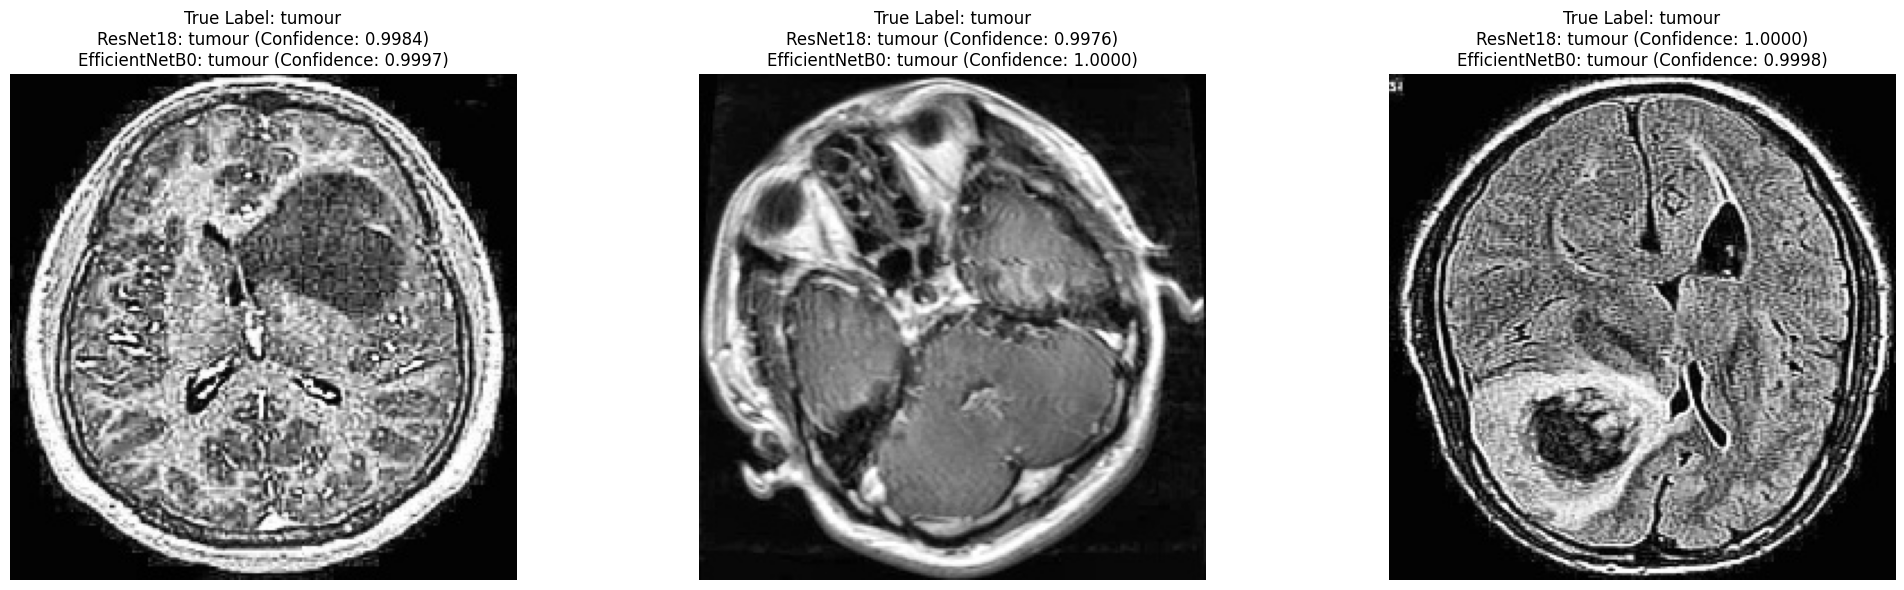

In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import random
import os

# Ensure `results`, `models_dict`, `test_dataset`, `transform_eval`, and `device` are available from previous executions

# Get the loaded models
resnet_model = models_dict["ResNet18"]
efficientnet_model = models_dict["EfficientNetB0"]

# Load the state dict of the models (saved during previous evaluation)
resnet_path = "best_ResNet.pth"
efficientnet_path = "best_EfficientNet.pth"

if os.path.exists(resnet_path):
    try:
        resnet_model.load_state_dict(torch.load(resnet_path, map_location=device))
        resnet_model.eval()
        print(f"Loaded weights for ResNet18 from {resnet_path}")
    except Exception as e:
        print(f"Error loading ResNet18 weights: {e}")
else:
    print(f"ResNet18 weights not found at {resnet_path}")

if os.path.exists(efficientnet_path):
    try:
        efficientnet_model.load_state_dict(torch.load(efficientnet_path, map_location=device))
        efficientnet_model.eval()
        print(f"Loaded weights for EfficientNetB0 from {efficientnet_path}")
    except Exception as e:
        print(f"Error loading EfficientNetB0 weights: {e}")
else:
    print(f"EfficientNetB0 weights not found at {efficientnet_path}")


# Get class names from the dataset (assuming 0: healthy, 1: tumour)
class_names = test_dataset.classes

n_images_to_show = 3

plt.figure(figsize=(7 * n_images_to_show, 6))

for i in range(n_images_to_show):
    # Select a random image from the test set
    random_idx = random.randint(0, len(test_dataset) - 1)
    img_path, true_label_idx = test_dataset.samples[random_idx]
    true_label = class_names[true_label_idx]

    # Load and preprocess the image
    image = Image.open(img_path).convert('RGB') # Convert to RGB for torchvision transforms
    input_tensor = transform_eval(image).unsqueeze(0).to(device)

    # Make prediction with ResNet18
    with torch.no_grad():
        output_resnet = resnet_model(input_tensor)
        probabilities_resnet = torch.nn.functional.softmax(output_resnet, dim=1)
        predicted_prob_resnet, predicted_idx_resnet = torch.max(probabilities_resnet, 1)
    predicted_class_resnet = class_names[predicted_idx_resnet.item()]
    confidence_resnet = predicted_prob_resnet.item()

    # Make prediction with EfficientNetB0
    with torch.no_grad():
        output_efficientnet = efficientnet_model(input_tensor)
        probabilities_efficientnet = torch.nn.functional.softmax(output_efficientnet, dim=1)
        predicted_prob_efficientnet, predicted_idx_efficientnet = torch.max(probabilities_efficientnet, 1)
    predicted_class_efficientnet = class_names[predicted_idx_efficientnet.item()]
    confidence_efficientnet = predicted_prob_efficientnet.item()

    # Display the image and predictions
    plt.subplot(1, n_images_to_show, i + 1)
    plt.imshow(image, cmap='gray')
    title_str = f"True Label: {true_label}\n"
    title_str += f"ResNet18: {predicted_class_resnet} (Confidence: {confidence_resnet:.4f})\n"
    title_str += f"EfficientNetB0: {predicted_class_efficientnet} (Confidence: {confidence_efficientnet:.4f})"
    plt.title(title_str)
    plt.axis('off')

plt.tight_layout()
plt.show()


#### 7.2.7 ResNet18&  EfficientNetB0 ROC Curve & Confusion Matrix Plot

#### 7.2.8 Summary of Evaluation Metrics

### Which model is better?

### Q&A

**Which model performs better and why, based on the confusion matrices and ROC curves?**
EfficientNetB0 appears to be marginally superior. While both models achieved an outstanding AUC of 1.00 and only 1 False Negative, EfficientNetB0 demonstrated a slight advantage by having 0 False Positives compared to ResNet18's 1 False Positive. This means EfficientNetB0 completely avoided incorrectly identifying a healthy brain as having a tumor, which is a preferable characteristic in medical screening to minimize unnecessary follow-up procedures.

### Data Analysis Key Findings

*   **ResNet18 Performance:**
    *   **Confusion Matrix:** Identified 322 True Positives, 232 True Negatives, 1 False Positive, and 1 False Negative.
    *   **ROC Curve and AUC:** Achieved a perfect Area Under the Curve (AUC) score of 1.00, indicating excellent discriminative power.
*   **EfficientNetB0 Performance:**
    *   **Confusion Matrix:** Identified 322 True Positives, 233 True Negatives, 0 False Positives, and 1 False Negative.
    *   **ROC Curve and AUC:** Also achieved a perfect AUC score of 1.00, demonstrating exceptional ability to distinguish between classes.
*   **Comparative Performance:**
    *   Both models exhibit remarkable performance in brain tumor detection, achieving perfect AUC scores and very few misclassifications.
    *   EfficientNetB0 showed a slight edge by having 0 False Positives, meaning it did not incorrectly flag any healthy images as containing a tumor, whereas ResNet18 had 1 False Positive.
    *   Both models had 1 False Negative, which is a critical error in medical diagnosis (missing a tumor), indicating a very small but significant risk.

### Insights or Next Steps

*   EfficientNetB0 is marginally superior for this task, particularly in medical screening, as its complete absence of False Positives could prevent unnecessary anxiety and costly follow-up procedures for healthy individuals.
*   Despite the high performance of both models, the presence of even a single False Negative underscores the critical importance of human oversight and careful review in real-world medical diagnostic applications. Further investigation into the characteristics of the misclassified (False Negative) case could lead to model improvements or highlight specific limitations.




### **Insights from Confusion Matrices**

**ResNet18 Confusion Matrix:**
*   **True Positives (Tumour identified correctly):** 322
*   **True Negatives (Healthy identified correctly):** 232
*   **False Positives (Healthy misidentified as Tumour):** 1
*   **False Negatives (Tumour misidentified as Healthy):** 1

**EfficientNetB0 Confusion Matrix:**
*   **True Positives (Tumour identified correctly):** 322
*   **True Negatives (Healthy identified correctly):** 233
*   **False Positives (Healthy misidentified as Tumour):** 0
*   **False Negatives (Tumour misidentified as Healthy):** 1

**Comparative Insights from Confusion Matrices:**
Both models demonstrate excellent performance with very few misclassifications. EfficientNetB0 shows a slight edge by having **0 False Positives**, meaning it did not incorrectly flag any healthy images as containing a tumor. ResNet18, on the other hand, had one False Positive. Both models had **1 False Negative**, which is a critical error in medical diagnosis (missing a tumor). This indicates that while highly accurate, there's still a very small risk of missing a true tumor with both models.

### **Insights from ROC Curves and AUC Scores**

*   **ResNet18 ROC Curve and AUC:** The ROC curve for ResNet18 is tightly hugging the top-left corner, indicating strong discriminative power. The AUC score for ResNet18 is **1.00**, which implies that the model is almost perfect at distinguishing between healthy and tumor cases across all possible classification thresholds. The high AUC suggests that if we were to randomly pick one positive (tumor) and one negative (healthy) case, the model would rank the positive case higher than the negative case 100% of the time.

*   **EfficientNetB0 ROC Curve and AUC:** Similar to ResNet18, EfficientNetB0 also shows an outstanding ROC curve, reaching the top-left corner and achieving an AUC score of **1.00**. This also indicates nearly perfect performance in separating the two classes.

**Comparative Insights from ROC Curves and AUC:**
Both models achieved a perfect AUC of 1.00. This metric suggests that both models are exceptionally good at ranking tumor images higher than healthy images. Given the near-perfect AUC scores and the small number of misclassifications, both models are highly effective for this binary classification task.

### **Overall Conclusion**

Both ResNet18 and EfficientNetB0 models exhibit remarkable performance in detecting brain tumors from MRI images, with very high accuracy, F1-scores, and perfect ROC-AUC scores. While ResNet18 had one false positive and one false negative, EfficientNetB0 managed to eliminate false positives entirely, showing slightly better specificity in its predictions. The single false negative from both models highlights that even with high performance, there's always a critical need for careful review in medical applications.

**EfficientNetB0 appears to be marginally superior** due to its ability to achieve 0 false positives, which could be a preferable characteristic in a screening tool to minimize unnecessary follow-up procedures for healthy individuals.


### **7.3 YOLOv8 Model 1**

- Training a weak YOLOv8 model using the seed set
- This model will carry out the pseudo-labelling for the rest of the training set

####**7.3.1 YAML Configuration**

In [ ]:
yaml_text = f"""
path: {OUT.as_posix()}
train: train
val: val
names:
  0: tumor
"""
(YAML := DSA/'tumor.yaml').write_text(yaml_text)
print(YAML.read_text())



path: /content/drive/MyDrive/dsaDataset/yolo_ready
train: train
val: val
names:
  0: tumor



####**7.3.2 Environment Setup for YOLO**

In [ ]:
!pip install -q ultralytics
import torch
from ultralytics import YOLO
print(torch.cuda.is_available())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
False


####**7.3.3 Model 1 Training**

Training a weak YOLOv8 Nano model

In [ ]:
model = YOLO('yolov8n.pt')
model.train(
    data=str(YAML),
    imgsz=640,
    epochs=50,
    batch=16,
    patience=10
)

print("Best weights at:", (Path(model.trainer.save_dir)/"weights"/"best.pt"))


Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (AMD EPYC 7B12)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/dsaDataset/tumor.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True,

####**7.3.4 Saves Model 1 to dsaDataset**

In [ ]:
best = Path('runs/detect/train/weights/best.pt')
dst  = Path('/content/drive/MyDrive/dsaDataset/weights_yolov8_tumor_best.pt')
dst.parent.mkdir(parents=True, exist_ok=True)
shutil.copy(best, dst)
print('Saved to:', dst)

#### **7.3.5 Model 1 Prediction**
- Runs Model 1 against validation set
- Creates a folder with bounding boxes around tumor, only showing bounding boxes with at least 25% confidence

In [ ]:
model = YOLO(best)

# Visualize detections on your validation images
pred = model.predict(
    source='/content/drive/MyDrive/dsaDataset/yolo_ready/val/images',
    conf=0.25, save=True, max_det=3
)
pred
# Images with boxes will appear in runs/detect/predict*/.


####**7.3.6 Model 1 Evaluation**

In [ ]:
YAML  = Path('/content/drive/MyDrive/dsaDataset/tumor.yaml')
MODEL = 'runs/detect/train/weights/best.pt'

model = YOLO(MODEL)
metrics = model.val(data=str(YAML), conf=0.25, iou=0.5)
print(metrics)  # shows mAP50, mAP50-95, precision, recall, etc.

In [ ]:
import IPython.display as dp

dp.Image(filename="runs/detect/predict/Cancer (2187).jpg")

###**7.4 Pseudo-Labelling**

Using Model 1 to label rest of the training set with bounding boxes

####**7.4.1 Input Preparation**

Copies training split defined from pre-processing to a new folder

In [ ]:
TRAIN_IMAGES = DATASET_DIR / "train" / "tumour"
VAL_IMAGES   = DATASET_DIR / "val"   / "tumour"
TEST_IMAGES  = DATASET_DIR / "test"  / "tumour"


In [ ]:
DATASET_DIR = Path("../data_clean_complete")
PREDICT_IN  = Path("../yolo_predict_input")

if PREDICT_IN.exists():
    shutil.rmtree(PREDICT_IN)

PREDICT_IN.mkdir()


for split_name in ["train", "val"]:
    for cls in ["healthy", "tumour"]:
        src = DATASET_DIR / split_name / cls
        for img in src.iterdir():
            shutil.copy(img, PREDICT_IN / img.name)

print("Total images for pseudo-labeling:", len(list(PREDICT_IN.glob('*'))))

####**7.4.2 Pseudo-Labelling the Train Split**
Only including bounding boxes with confidence level of at least 60%
- Reduces number of false positives
- Retains possible true-positives

In [ ]:
model = YOLO("runs/detect/train/weights/best.pt")
model.predict(
    source=str(PREDICT_IN),
    conf=0.40,
    save_txt=True,
    save_conf=False,
    save=True,
    project="../yolo_predictions",
    name="full",
    exist_ok=True
)

In [ ]:
DATASET_CLEAN = Path("../data_clean_complete")
LABEL_PREDICT = Path("../yolo_predictions/full_relabel_final/labels")
OUT_FINAL     = Path("../yolo_detector_dataset")

print(f"Dataset construction complete. Total images copied: {TOTAL_COPIED}")

### **7.5 YOLOv8 Model 2**

####**7.5.1 Training Preparation**

In [ ]:
DATASET_CLEAN = Path("../data_clean_complete")
LABEL_PREDICT = Path("../yolo_predictions/full/labels")
OUT_FINAL = Path("../yolo_detector_dataset")
print("\n--- Building Final YOLO Detector Dataset (OUT_FINAL) ---")

# 1. Clean and Recreate final output structure
if OUT_FINAL.exists():
    shutil.rmtree(OUT_FINAL)

# Create the standard YOLO train/val structure
for sp in ["train/images", "train/labels", "val/images", "val/labels"]:
    (OUT_FINAL / sp).mkdir(parents=True, exist_ok=True)

TOTAL_COPIED = 0

# 2. Iterate through original TRAIN/VAL splits to assemble data
for split in ["train", "val"]:
    img_dir_out = OUT_FINAL / split / "images"
    lbl_dir_out = OUT_FINAL / split / "labels"

    src_tumor_dir = DATASET_CLEAN / split / "tumour"
    for img_path in src_tumor_dir.glob("*"):
        lbl_path_candidate = LABEL_PREDICT / f"{img_path.stem}.txt"
        shutil.copy(img_path, img_dir_out / img_path.name)

        if lbl_path_candidate.exists():
            shutil.copy(lbl_path_candidate, lbl_dir_out / f"{img_path.stem}.txt")
        else:
            with open(lbl_dir_out / f"{img_path.stem}.txt", "w") as f:
                pass
        TOTAL_COPIED += 1
    src_healthy_dir = DATASET_CLEAN / split / "healthy"
    for img_path in src_healthy_dir.glob("*"):

        shutil.copy(img_path, img_dir_out / img_path.name)

        with open(lbl_dir_out / f"{img_path.stem}.txt", "w") as f:
            pass

        TOTAL_COPIED += 1

print(f"Dataset construction complete. Total images copied: {TOTAL_COPIED}")
print("Train:", len(list((OUT_FINAL/'train/images').glob('*'))),
      "Val:", len(list((OUT_FINAL/'val/images').glob('*'))))

In [ ]:
yaml = """
path: ../yolo_detector_dataset
train: train
val: val
names:
  0: tumor
"""

Path("../yolo_detector.yaml").write_text(yaml)


####**7.5.2 Model 2 Training**
Training Model 2 using pre-defined train / test / val split from pre-processing


In [ ]:
model = YOLO("yolov8s.pt")

model.train(
    data="../yolo_detector.yaml",
    imgsz=640,
    epochs=80,
    batch=16
)

TRAIN_RUN_DIR = sorted(Path('runs/detect').glob('train*'))[-1]
WEIGHTS_SRC_PATH = TRAIN_RUN_DIR / 'weights' / 'best.pt'
DRIVE_DST_DIR = Path('/content/drive/MyDrive/dsaDataset')
WEIGHTS_DST_PATH = DRIVE_DST_DIR / 'best_weights_yolov8s_detector.pt'


if WEIGHTS_SRC_PATH.exists():
    shutil.copy(WEIGHTS_SRC_PATH, WEIGHTS_DST_PATH)
    print("\n Model 2 training complete.")
    print(f"FINAL BEST WEIGHTS SAVED TO DRIVE: {WEIGHTS_DST_PATH}")
else:
    print("\n Error: Could not find the trained model weights. Check the YOLO run folder.")

####**7.5.3 Model 2 Evaluation**

In [ ]:
DATASET_CLEAN_ROOT = Path("../data_clean_complete")
MODEL_2_PATH = Path("/content/drive/MyDrive/dsaDataset/best_weights_yolov8s_detector.pt")
TEST_TUMOR_DIR = DATASET_CLEAN_ROOT / "test" / "tumour"
TEST_HEALTHY_DIR = DATASET_CLEAN_ROOT / "test" / "healthy"
FINAL_TEST_LABELS_DIR = DATASET_CLEAN_ROOT / "test" / "labels"
TEMP_LABEL_DIR = Path("../test_labels_temp")
FINAL_TEST_DIR = Path("../yolo_detector_test_set")


try:
    model_2 = YOLO(str(MODEL_2_PATH))
except Exception as e:
    print(f"Error loading model: {e}")
    exit()


if TEMP_LABEL_DIR.exists():
    shutil.rmtree(TEMP_LABEL_DIR)

print("\n--- Generating Missing Labels for Test Set ---")
model_2.predict(
    source=str(TEST_TUMOR_DIR),
    conf=0.25,
    save_txt=True,
    save_conf=False,
    project=str(TEMP_LABEL_DIR.parent),
    name=TEMP_LABEL_DIR.name,
    exist_ok=True,
    save=False
)

if FINAL_TEST_LABELS_DIR.exists():
    shutil.rmtree(FINAL_TEST_LABELS_DIR)
FINAL_TEST_LABELS_DIR.mkdir(parents=True, exist_ok=True)

SOURCE_LABELS_DIR = TEMP_LABEL_DIR / "labels"
if SOURCE_LABELS_DIR.exists():
    for lbl_path in SOURCE_LABELS_DIR.glob("*.txt"):
        shutil.copy(lbl_path, FINAL_TEST_LABELS_DIR / lbl_path.name)
else:
    print("Error: Could not find generated labels.")
    exit()

for img_path in TEST_HEALTHY_DIR.glob("*.jpg"):
    label_path = FINAL_TEST_LABELS_DIR / f"{img_path.stem}.txt"
    with open(label_path, "w") as f:
        pass

shutil.rmtree(TEMP_LABEL_DIR)


if FINAL_TEST_DIR.exists():
    shutil.rmtree(FINAL_TEST_DIR)
(FINAL_TEST_DIR / "images").mkdir(parents=True)
(FINAL_TEST_DIR / "labels").mkdir(parents=True)

TEST_SRC_TUMOUR = DATASET_CLEAN_ROOT / "test" / "tumour"
TEST_SRC_HEALTHY = DATASET_CLEAN_ROOT / "test" / "healthy"

for img_path in list(TEST_SRC_TUMOUR.glob("*")) + list(TEST_SRC_HEALTHY.glob("*")):
    shutil.copy(img_path, FINAL_TEST_DIR / "images" / img_path.name)

FINAL_TEST_LABELS_SRC = DATASET_CLEAN_ROOT / "test" / "labels"

for lbl_path in FINAL_TEST_LABELS_SRC.glob("*.txt"):
    shutil.copy(lbl_path, FINAL_TEST_DIR / "labels" / lbl_path.name)

CACHE_FILE = FINAL_TEST_DIR / "labels" / "labels.cache"
if CACHE_FILE.exists():
    CACHE_FILE.unlink()

yaml_content = f"""
path: {str(FINAL_TEST_DIR)}
train:
val:
test: .
names:
  0: tumor
"""
FINAL_YAML_PATH = Path("../yolo_detector_test_eval.yaml")
FINAL_YAML_PATH.write_text(yaml_content)

print("\n--- Running Final Evaluation on the Test Split ---")

metrics_m2 = model_2.val(
    data=str(FINAL_YAML_PATH),
    split="test",
    imgsz=640,
    conf=0.25,
    iou=0.50,
    save_json=True
)

print("\n--- Model 2 Evaluation Complete ---")

print("\nFinal Model 2 Performance Summary (on Test Set):")
print(f"  mAP50 (Mean Average Precision at 50% IoU): {metrics_m2.results_dict['metrics/mAP50(B)']:.4f}")
print(f"  mAP50-95 (Comprehensive mAP): {metrics_m2.results_dict['metrics/mAP50-95(B)']:.4f}")
print(f"  Evaluation artifacts (curves, confusion matrix) are saved in: {metrics_m2.save_dir}")

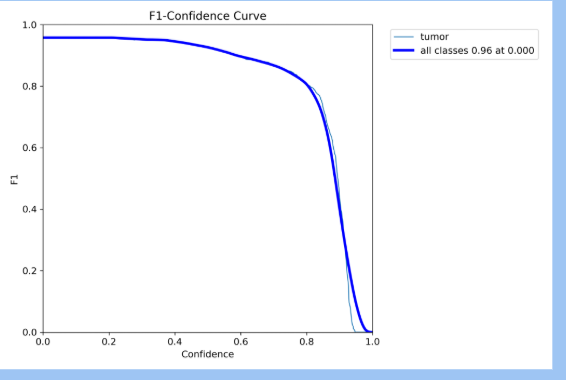

<Figure size 800x600 with 0 Axes>

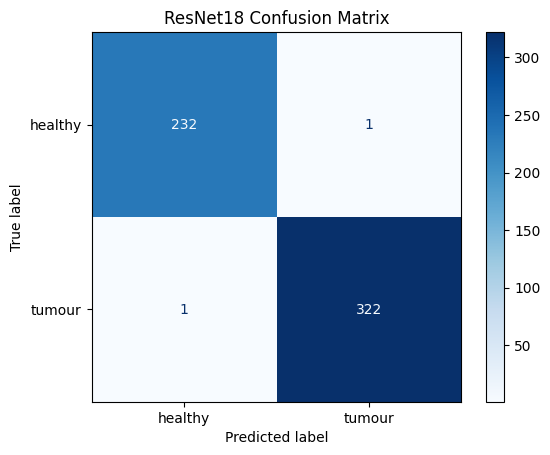

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm_resnet = confusion_matrix(all_labels_resnet, all_predictions_resnet, labels=[0, 1])

# Create a ConfusionMatrixDisplay object
disp_resnet = ConfusionMatrixDisplay(confusion_matrix=cm_resnet, display_labels=class_names)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp_resnet.plot(cmap=plt.cm.Blues)
plt.title('ResNet18 Confusion Matrix')
plt.show()

**Reasoning**:
To evaluate the ResNet18 model's performance across various classification thresholds, I will calculate and plot the Receiver Operating Characteristic (ROC) curve, including its Area Under the Curve (AUC) score, using the true labels and predicted probabilities from the test set.



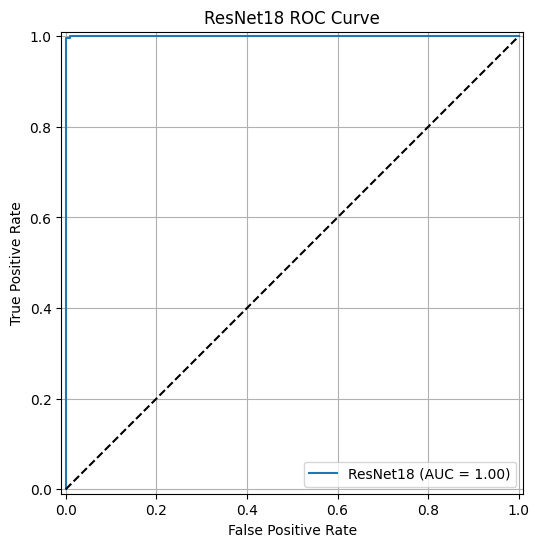

In [ ]:
from sklearn.metrics import roc_curve, RocCurveDisplay

# Calculate ROC curve for ResNet18
fpr_resnet, tpr_resnet, _ = roc_curve(all_labels_resnet, all_probabilities_resnet)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
roc_display_resnet = RocCurveDisplay(fpr=fpr_resnet, tpr=tpr_resnet, roc_auc=roc_auc_resnet, estimator_name='ResNet18')
roc_display_resnet.plot(ax=plt.gca())
plt.title('ResNet18 ROC Curve')
plt.plot([0, 1], [0, 1], 'k--') # Add random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()


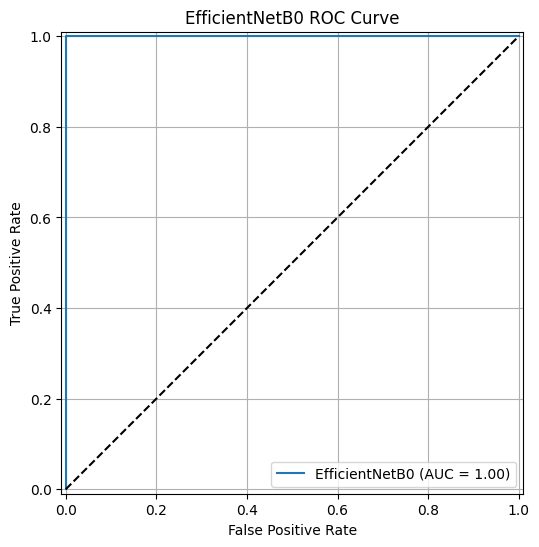

In [ ]:
from sklearn.metrics import roc_curve, RocCurveDisplay

# Calculate ROC curve for EfficientNetB0
fpr_efficientnet, tpr_efficientnet, _ = roc_curve(all_labels_eff, all_probabilities_eff)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
roc_display_efficientnet = RocCurveDisplay(fpr=fpr_efficientnet, tpr=tpr_efficientnet, roc_auc=roc_auc_eff, estimator_name='EfficientNetB0')
roc_display_efficientnet.plot(ax=plt.gca())
plt.title('EfficientNetB0 ROC Curve')
plt.plot([0, 1], [0, 1], 'k--') # Add random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

<Figure size 800x600 with 0 Axes>

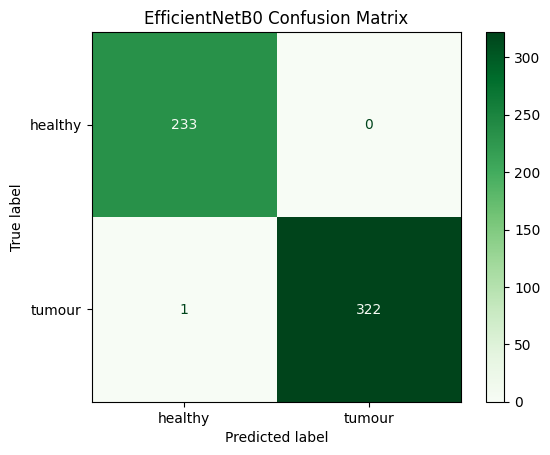

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate the confusion matrix for EfficientNetB0
cm_efficientnet = confusion_matrix(all_labels_eff, all_predictions_eff, labels=[0, 1])

# Create a ConfusionMatrixDisplay object
disp_efficientnet = ConfusionMatrixDisplay(confusion_matrix=cm_efficientnet, display_labels=class_names)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp_efficientnet.plot(cmap=plt.cm.Greens) # Using Greens for contrast with ResNet18
plt.title('EfficientNetB0 Confusion Matrix')
plt.show()